In [144]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

In [215]:
method_replacement_dict = {"difference": "Difference",
                           "initial": "Initial Parameters",
                           "late_em": "Late EM",
                           "pure_competency": "Pure Competency", 
                           "real_early": "Real early Param.",
                           "real_parameters": "Real Param."}


def parameter_table_model(df, latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    rmse_columns = ["method", "sample_size", "rmse_early_A", "rmse_early_delta", "rmse_early_sigma",
                    "rmse_late_A", "rmse_late_delta", "rmse_late_sigma", "rmse_psi"]
    sub_df = sub_df[rmse_columns]
    columns = ["Method","Sample size", "$A^e$", "$\Delta^e$", "$\Sigma^e$",
                       "$A^l$", "$\Delta^l$", "$\Sigma^l$", "$\Psi$"]
    sub_df.columns = columns
    sub_df = sub_df.replace(method_replacement_dict)
    parameter_table = sub_df.groupby(["Sample size", "Method"]).agg(aggfunc)
    parameter_table = np.round(parameter_table, decimals)
    #parameter_table.columns = pd.MultiIndex.from_product([["RMSE"], parameter_table.columns], names=['Metric', ''])
    
    #columns = list(zip(["RMSE" for i in range(0, len(columns))],parameter_table.columns))
    #parameter_table.columns = columns
    print(parameter_table.to_latex(bold_rows=True, multirow=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(parameter_table)


In [221]:
# Make one combined Model-fit table for all Q-Matrices
def likelihood_table_model(df_list, Q_names=["Full Q", "Seperated Q", "Pyramid Q"], latent_dimension=2, item_dimension=20, aggfunc="median", caption="", decimals=3):
    combined_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        q_df = combined_df[["early_l_estimated", "late_l_estimated", "method", "sample_size"]]
        q_df["Q-type"] = Q_names[i]
        combined_df = pd.concat((combined_df, q_df), axis=0)
    fit_table = pd.crosstab(index=[combined_df["sample_size"], combined_df["method"]], 
                            columns=[combined_df["Q-type"]]
                            values=[combined_df["early_l_estimated"], combined_df["late_l_estimated"]],
                            aggfunc=aggfunc)
    return(fit_table)

# TODO: Maybe include empirical likelihood not only marginal?

In [216]:
def single_metric_table(df, metric, aggfunc="median", latex=True, decimals=3, caption=""):
    df = df.replace(method_replacement_dict)
    n = np.min(df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    table = pd.crosstab(index=[df["sample_size"], df["method"]],
                columns=[df["latent_dimension"], df["item_dimension"]], 
                values=df[metric], 
                aggfunc=aggfunc)
    table = np.round(table, decimals)
    if latex:
        print(table.to_latex(bold_rows=True, multirow=True, 
                             caption=caption+", n={0}".format(n),
                             position="H"))
    return(table)

In [217]:
def model_boxplot(df, metric='rmse_psi', latent_dimension=2, item_dimension=20, 
                  title="",
                  methods=["late_em", "real_early", "pure_competency", "initial", "difference"]):
    sub_df = df[(df["latent_dimension"] == 2) & (df["item_dimension"] == 20)]
    sub_df = sub_df[(sub_df["method"].isin(methods))]
    sub_df = sub_df.replace(method_replacement_dict)
    n =np.min(sub_df.groupby(["latent_dimension", "item_dimension", "sample_size"])["method"].value_counts())
    fig = plt.gcf()
    fig.set_dpi(100)
    fig.set_size_inches(10, 5)
    plt.title(title+", n={0}".format(n))
    sn.boxplot(x=sub_df[metric], hue=sub_df["sample_size"].astype("str"), y=sub_df["method"],
               orient="h")

# Results

## Simulatuion Results

### Full Q Matrix

In [218]:
full_Q_df.columns

Index(['latent_dimension', 'item_dimension', 'sample_size', 'key', 'method',
       'early_runtime', 'late_runtime', 'early_steps', 'late_steps',
       'early_l_optimal', 'early_l_estimated', 'late_l_optimal',
       'late_l_estimated', 'rmse_early_A', 'rmse_early_delta',
       'rmse_early_sigma', 'rmse_late_A', 'rmse_late_delta', 'rmse_psi',
       'rmse_late_sigma', 'rmse_theta', 'rmse_gain_estimated',
       'rmse_gain_pred_train'],
      dtype='object')

In [219]:
full_Q_df = pd.read_csv("results/full_q.csv")
full_Q_df

,latent_dimension,item_dimension,sample_size,key,method,early_runtime,late_runtime,early_steps,late_steps,early_l_optimal,...,rmse_early_A,rmse_early_delta,rmse_early_sigma,rmse_late_A,rmse_late_delta,rmse_psi,rmse_late_sigma,rmse_theta,rmse_gain_estimated,rmse_gain_pred_train
0,2,10,30,2022-11-12 16:24:53.682742,late_em,2.61,10.89,8.0,7.0,-174.18,...,0.742549,0.606349,0.115895,1.598734,0.955070,0.397069,0.245787,0.614367,0.859266,0.924723
1,2,10,30,2022-11-12 16:24:53.682742,initial,0.00,0.00,0.0,0.0,-174.53,...,0.777075,0.588126,0.075802,2.028522,2.071094,0.398160,0.251788,0.604733,1.034028,0.927680
2,2,10,30,2022-11-12 16:24:53.682742,difference,2.36,3.63,7.0,9.0,-173.95,...,0.613422,0.566254,0.115683,1.012180,1.793744,0.327652,0.157704,0.608434,0.834815,0.864972
3,2,10,30,2022-11-12 16:24:53.682742,real_early,NaN,11.11,NaN,7.0,NaN,...,NaN,NaN,NaN,1.277630,0.803144,0.402470,0.192169,0.000000,0.772054,0.927784
4,2,10,30,2022-11-12 16:24:53.682742,pure_competency,1.99,10.70,7.0,7.0,-174.20,...,0.666380,0.597824,0.277752,1.179583,1.025585,0.387721,0.174870,0.596721,0.786423,0.915762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2,10,30,2022-11-12 18:25:01.171247,initial,0.00,0.00,0.0,0.0,-161.09,...,1.140223,0.400369,0.353553,1.338848,2.091471,0.155720,0.225191,0.679120,0.817450,0.886520
68,2,10,30,2022-11-12 18:25:01.171247,difference,3.44,3.39,10.0,10.0,-161.04,...,2.224306,0.497812,0.317562,1.440030,1.104109,0.315775,0.281724,0.665779,0.773124,0.891620
69,2,10,30,2022-11-12 18:25:01.171247,real_early,NaN,16.30,NaN,9.0,NaN,...,NaN,NaN,NaN,0.792652,0.743459,0.160251,0.123950,0.000000,0.743486,0.887034
70,2,10,30,2022-11-12 18:25:01.171247,pure_competency,2.64,20.37,9.0,11.0,-161.16,...,2.198918,0.789606,0.000000,2.726208,3.544446,0.143146,0.188888,0.668483,0.775034,0.916209


In [220]:
parameter_table_model(full_Q_df, caption="Full Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Full Q-Matrix, Reference Model, n=1}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.536 &       0.286 &       0.015 &  1.110 &       0.704 &       0.220 &   0.198 \\
    & \textbf{Initial Parameters} &  1.451 &       0.361 &       0.354 &  1.407 &       1.677 &       0.368 &   0.113 \\
    & \textbf{Late EM} &  0.497 &       0.302 &       0.007 &  1.312 &       0.780 &       0.162 &   0.216 \\
    & \textbf{Pure Competency} &  0.528 &       0.278 &       0.000 &  1.673 &       2.187 &       0.339 &   0.087 \\
    & \textbf{Real Param.} &    NaN &         NaN &         NaN &  0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real early Param.} &    NaN 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\3880013651.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
100         Difference          0.536       0.286       0.015  1.110   
            Initial Parameters  1.451       0.361       0.354  1.407   
            Late EM             0.497       0.302       0.007  1.312   
            Pure Competency     0.528       0.278       0.000  1.673   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  1.428   
200         Difference          0.516       0.405       0.081  0.350   
            Initial Parameters  1.291       0.740       0.057  1.284   
            Late EM             0.439       0.362       0.095  1.044   
            Pure Competency     0.396       0.368       0.410  0.423   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  0.421   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
100         Difference               0.704       0.220   0.198  
            Initial Parameters       1.677       0.368   0.113  
            Late EM                  0.780       0.162   0.216  
            Pure Competency          2.187       0.339   0.087  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.677       0.140   0.209  
200         Difference               0.951       0.075   0.370  
            Initial Parameters       1.714       0.621   0.390  
            Late EM                  0.972       0.486   0.288  
            Pure Competency          0.883       0.376   0.302  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        1.023       0.380   0.387

In [201]:
single_metric_table(full_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=1}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{6}{*}{\textbf{30 }} & \textbf{Difference} &  0.328 &    NaN &  0.280 &  0.278 \\
    & \textbf{Initial Parameters} &  0.398 &    NaN &  0.298 &  0.188 \\
    & \textbf{Late EM} &  0.397 &    NaN &  0.342 &  0.164 \\
    & \textbf{Pure Competency} &  0.388 &    NaN &  0.268 &  0.163 \\
    & \textbf{Real Param.} &  0.000 &    NaN &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.402 &    NaN &  0.349 &  0.149 \\
\cline{1-6}
\multirow{6}{*}{\textbf{100}} & \textbf{Difference} &  0.361 &  0.198 &  0.278 &  0.224 \\
    & \textbf{Initial Parameters} &  0.518 &  0.113 &  0.338 &  0.286 \\
    & \textbf{Late EM} &  0.460 &  0.216 & 

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.328    NaN  0.280  0.278
            Initial Parameters  0.398    NaN  0.298  0.188
            Late EM             0.397    NaN  0.342  0.164
            Pure Competency     0.388    NaN  0.268  0.163
            Real Param.         0.000    NaN  0.000  0.000
            Real early Param.   0.402    NaN  0.349  0.149
100         Difference          0.361  0.198  0.278  0.224
            Initial Parameters  0.518  0.113  0.338  0.286
            Late EM             0.460  0.216  0.322  0.235
            Pure Competency     0.368  0.087  0.323  0.273
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.476  0.209  0.288  0.225
200         Difference          0.245  0.370  0.331    NaN
            Initial Parameters  0.441  0.390  0.349    NaN
            Late EM             0.443  0.288  0.396    NaN
            Pure Competency     0.185  0.302  0.338    NaN
            Real Param.         0.000  0.000  0.000    NaN
            Real early Param.   0.424  0.387  0.409    NaN

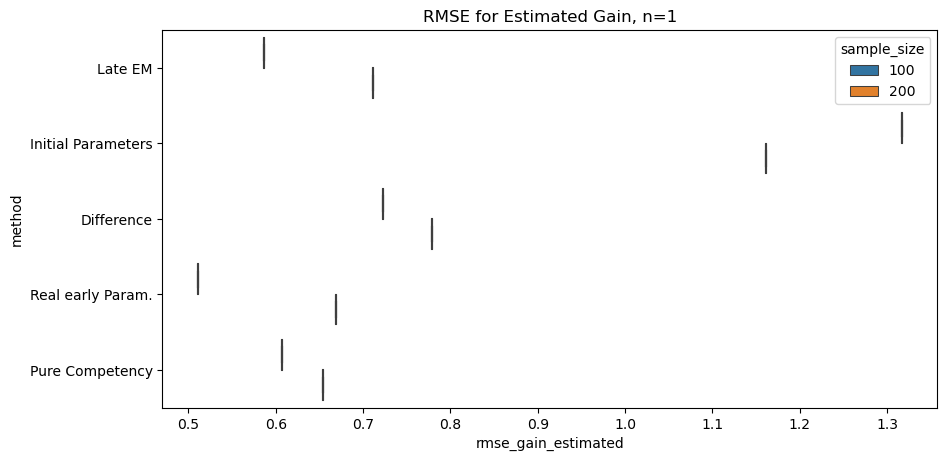

In [202]:
model_boxplot(full_Q_df, metric='rmse_gain_estimated', title="RMSE for Estimated Gain")

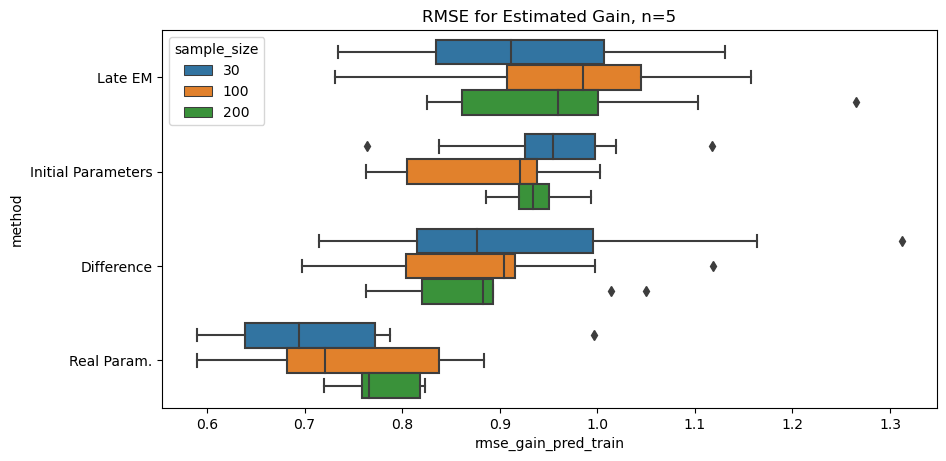

In [34]:
model_boxplot(full_Q_df, metric='rmse_gain_pred_train', title="RMSE for Estimated Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency"])

### Seperated Q-Matrix

In [35]:
sep_Q_df = pd.read_csv("results/seperated_q.csv")
sep_Q_df

,latent_dimension,item_dimension,sample_size,key,method,early_runtime,late_runtime,early_steps,late_steps,early_l_optimal,...,rmse_early_A,rmse_early_delta,rmse_early_sigma,rmse_late_A,rmse_late_delta,rmse_psi,rmse_late_sigma,rmse_theta,rmse_gain_estimated,rmse_gain_pred_train
0,2,10,30,2022-11-11 20:10:46.806576,late_em,3.88,32.43,9.0,11.0,-164.81,...,3.897704,2.480557,0.082449,1.739052,2.283198,0.406769,0.245032,0.546074,0.775638,1.071172
1,2,10,30,2022-11-11 20:10:46.806576,initial,0.00,0.00,0.0,0.0,-164.92,...,0.970106,0.551513,0.112501,1.673810,1.682831,0.292980,0.296856,0.538587,0.907553,1.017762
2,2,10,30,2022-11-11 20:10:46.806576,difference,5.22,6.28,10.0,13.0,-165.13,...,4.185228,2.493755,0.069579,2.173439,2.642210,0.260908,0.085470,0.548960,0.812639,1.063743
3,2,10,30,2022-11-11 20:10:46.806576,real_early,NaN,20.32,NaN,9.0,NaN,...,NaN,NaN,NaN,1.574241,1.126426,0.422674,0.205387,0.000000,0.766164,1.069775
4,2,10,30,2022-11-11 20:10:46.806576,real_parameters,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.519381,0.650539,0.982180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,2,20,100,2022-11-12 08:59:41.852719,initial,0.00,0.00,0.0,0.0,-1050.27,...,0.865803,0.509543,0.068094,2.113920,1.383574,0.251048,0.363954,0.460258,0.943019,0.997490
598,2,20,100,2022-11-12 08:59:41.852719,difference,4.32,5.44,7.0,8.0,-1051.88,...,0.283944,0.227620,0.019658,1.372515,0.831676,0.239030,0.143157,0.381634,0.763729,0.994709
599,2,20,100,2022-11-12 08:59:41.852719,real_early,NaN,58.65,NaN,10.0,NaN,...,NaN,NaN,NaN,1.803167,0.608401,0.424080,0.280816,0.000000,0.604355,1.079177
600,2,20,100,2022-11-12 08:59:41.852719,pure_competency,6.06,40.98,7.0,8.0,-1051.95,...,0.319262,0.240909,0.421648,1.490843,0.545090,0.218565,0.267290,0.405269,0.614856,0.981848


In [36]:
parameter_table_model(sep_Q_df, caption="Seperated Q-Matrix, Reference Model")

\begin{table}[H]
\centering
\caption{Seperated Q-Matrix, Reference Model, n=1}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &  $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &        &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  1.472 &       1.007 &       0.103 &  3.306 &       2.364 &       0.222 &   0.284 \\
    & \textbf{Initial Parameters} &  1.052 &       0.557 &       0.132 &  1.217 &       1.472 &       0.424 &   0.404 \\
    & \textbf{Late EM} &  1.739 &       1.036 &       0.113 &  4.849 &       3.325 &       0.188 &   0.325 \\
    & \textbf{Real Param.} &    NaN &         NaN &         NaN &  0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  4.569 &       3.677 &       0.176 &   0.351 \\
\cline{1-9}
\multirow{6}{*}{\textbf

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\3041005320.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$  $A^l$  \
Sample size Method                                                     
30          Difference          1.472       1.007       0.103  3.306   
            Initial Parameters  1.052       0.557       0.132  1.217   
            Late EM             1.739       1.036       0.113  4.849   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  4.569   
100         Difference          0.454       0.387       0.039  0.569   
            Initial Parameters  1.076       0.534       0.099  1.289   
            Late EM             0.523       0.412       0.043  0.872   
            Pure Competency     0.319       0.241       0.422  1.491   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  0.956   
200         Difference          0.326       0.310       0.035  0.441   
            Initial Parameters  1.072       0.425       0.148  1.535   
            Late EM             0.337       0.299       0.030  0.792   
            Real Param.           NaN         NaN         NaN  0.000   
            Real early Param.     NaN         NaN         NaN  0.610   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               2.364       0.222   0.284  
            Initial Parameters       1.472       0.424   0.404  
            Late EM                  3.325       0.188   0.325  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        3.677       0.176   0.351  
100         Difference               0.816       0.106   0.214  
            Initial Parameters       1.390       0.467   0.342  
            Late EM                  0.782       0.190   0.446  
            Pure Competency          0.545       0.267   0.219  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.776       0.201   0.428  
200         Difference               0.438       0.107   0.211  
            Initial Parameters       1.495       0.357   0.323  
            Late EM                  1.260       0.208   0.481  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.874       0.207   0.511

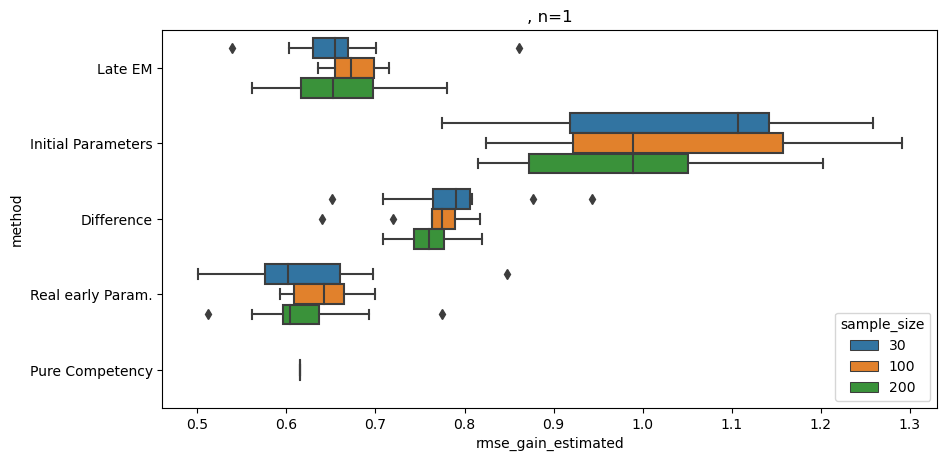

In [37]:
model_boxplot(sep_Q_df, metric='rmse_gain_estimated')

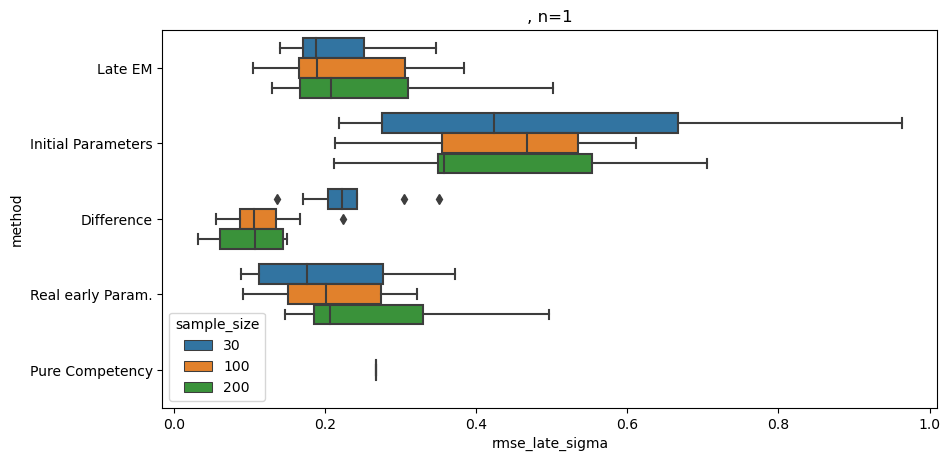

In [38]:
model_boxplot(sep_Q_df, metric='rmse_late_sigma')

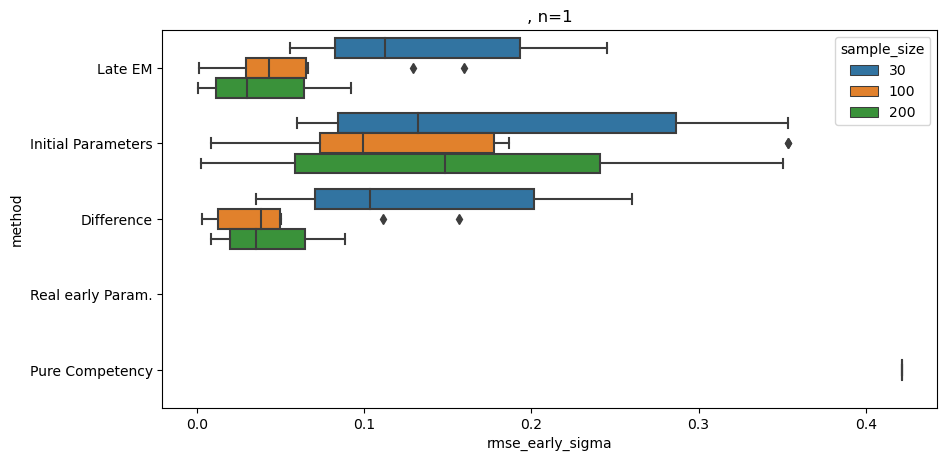

In [39]:
model_boxplot(sep_Q_df, metric='rmse_early_sigma')

### Pyramid Q-Matrix

In [40]:
pyramid_Q_df = pd.read_csv("results/pyramid_q.csv")
pyramid_Q_df

,latent_dimension,item_dimension,sample_size,key,method,early_runtime,late_runtime,early_steps,late_steps,early_l_optimal,...,rmse_early_A,rmse_early_delta,rmse_early_sigma,rmse_late_A,rmse_late_delta,rmse_psi,rmse_late_sigma,rmse_theta,rmse_gain_estimated,rmse_gain_pred_train
0,2,10,30,2022-11-11 20:10:03.008597,late_em,3.93,33.18,10.0,15.0,-139.10,...,1.892845,0.813903,0.207394,5.238504,5.014254,0.481057,0.558490,0.748685,1.020432,1.249737
1,2,10,30,2022-11-11 20:10:03.008597,initial,0.00,0.00,0.0,0.0,-138.74,...,1.355682,0.599879,0.094045,2.002059,2.038374,0.481057,0.558490,0.693160,1.059451,1.249737
2,2,10,30,2022-11-11 20:10:03.008597,difference,4.46,7.06,12.0,14.0,-138.75,...,2.306002,1.093162,0.192192,6.008709,9.107181,0.323273,0.342186,0.754195,0.972409,1.113135
3,2,10,30,2022-11-11 20:10:03.008597,real_early,NaN,48.49,NaN,14.0,NaN,...,NaN,NaN,NaN,3.464320,5.807348,0.201039,0.133030,0.000000,0.749674,0.898265
4,2,10,30,2022-11-11 20:10:03.008597,real_parameters,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.717620,0.521308,0.762569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,3,20,200,2022-11-12 09:49:15.221270,late_em,8.95,313.11,11.0,13.0,-1750.02,...,0.511127,0.466596,0.211485,1.262024,0.875736,0.538583,0.301019,0.613517,0.746294,1.150407
586,3,20,200,2022-11-12 09:49:15.221270,initial,0.00,0.00,0.0,0.0,-1751.51,...,1.194488,0.782707,0.230648,1.477446,1.456831,0.322017,0.438462,0.650135,1.290000,1.026174
587,3,20,200,2022-11-12 09:49:15.221270,difference,6.25,8.47,8.0,10.0,-1747.13,...,0.603472,0.362043,0.225310,0.943762,0.925482,0.384614,0.150808,0.622576,1.034205,1.056586
588,3,20,200,2022-11-12 09:49:15.221270,real_early,NaN,165.04,NaN,9.0,NaN,...,NaN,NaN,NaN,1.460378,0.787042,0.508324,0.224604,0.000000,0.725322,1.132098


In [41]:
parameter_table_model(full_Q_df, caption="Pyramid-Q-Matrix, RMSE Median of Parameter Recovery")

\begin{table}[H]
\centering
\caption{Pyramid-Q-Matrix, RMSE Median of Parameter Recovery, n=5}
\begin{tabular}{llrrrrrrr}
\toprule
    &                   &  $A^e$ &  $\Delta^e$ &  $\Sigma^e$ &   $A^l$ &  $\Delta^l$ &  $\Sigma^l$ &  $\Psi$ \\
\textbf{Sample size} & \textbf{Method} &        &             &             &         &             &             &         \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  2.315 &       1.826 &       0.127 &   7.320 &       5.631 &       0.186 &   0.292 \\
    & \textbf{Initial Parameters} &  1.537 &       0.633 &       0.129 &   1.399 &       1.763 &       0.378 &   0.354 \\
    & \textbf{Late EM} &  2.413 &       1.774 &       0.114 &  17.882 &       8.194 &       0.229 &   0.295 \\
    & \textbf{Real Param.} &    NaN &         NaN &         NaN &   0.000 &       0.000 &       0.000 &   0.000 \\
    & \textbf{Real early Param.} &    NaN &         NaN &         NaN &  12.712 &       7.713 &       0.230 &   0.315 \\
\cline{1-9}


C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\3041005320.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(parameter_table.to_latex(bold_rows=True, multirow=True,


$A^e$  $\Delta^e$  $\Sigma^e$   $A^l$  \
Sample size Method                                                      
30          Difference          2.315       1.826       0.127   7.320   
            Initial Parameters  1.537       0.633       0.129   1.399   
            Late EM             2.413       1.774       0.114  17.882   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN  12.712   
100         Difference          0.632       0.455       0.092   0.783   
            Initial Parameters  1.238       0.482       0.164   1.307   
            Late EM             0.621       0.436       0.101   1.069   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   1.108   
200         Difference          0.465       0.306       0.073   0.588   
            Initial Parameters  1.316       0.506       0.106   1.464   
            Late EM             0.520       0.287       0.096   0.861   
            Real Param.           NaN         NaN         NaN   0.000   
            Real early Param.     NaN         NaN         NaN   0.696   

                                $\Delta^l$  $\Sigma^l$  $\Psi$  
Sample size Method                                              
30          Difference               5.631       0.186   0.292  
            Initial Parameters       1.763       0.378   0.354  
            Late EM                  8.194       0.229   0.295  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        7.713       0.230   0.315  
100         Difference               1.038       0.109   0.206  
            Initial Parameters       1.627       0.315   0.325  
            Late EM                  1.762       0.250   0.426  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        1.189       0.217   0.432  
200         Difference               0.657       0.092   0.183  
            Initial Parameters       1.820       0.329   0.335  
            Late EM                  1.054       0.379   0.419  
            Real Param.              0.000       0.000   0.000  
            Real early Param.        0.859       0.355   0.439

In [42]:
single_metric_table(pyramid_Q_df, "rmse_psi", caption="RMSE for Correlations $\Psi$")

\begin{table}[H]
\centering
\caption{RMSE for Correlations $\Psi$, n=8}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.281 &  0.261 &  0.295 &  0.280 \\
    & \textbf{Initial Parameters} &  0.335 &  0.369 &  0.291 &  0.317 \\
    & \textbf{Late EM} &  0.291 &  0.376 &  0.250 &  0.292 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
    & \textbf{Real early Param.} &  0.276 &  0.321 &  0.302 &  0.316 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.230 &  0.307 &  0.323 &  0.283 \\
    & \textbf{Initial Parameters} &  0.283 &  0.308 &  0.339 &  0.355 \\
    & \textbf{Late EM} &  0.234 &  0.381 &  0.344 &  0.318 \\
    & \textbf{Real Param.} &  0.000 &  0.000 &  0.0

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.281  0.261  0.295  0.280
            Initial Parameters  0.335  0.369  0.291  0.317
            Late EM             0.291  0.376  0.250  0.292
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.276  0.321  0.302  0.316
100         Difference          0.230  0.307  0.323  0.283
            Initial Parameters  0.283  0.308  0.339  0.355
            Late EM             0.234  0.381  0.344  0.318
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.234  0.384  0.394  0.347
200         Difference          0.289  0.230  0.316  0.284
            Initial Parameters  0.314  0.273  0.298  0.292
            Late EM             0.432  0.448  0.363  0.450
            Real Param.         0.000  0.000  0.000  0.000
            Real early Param.   0.480  0.562  0.428  0.493

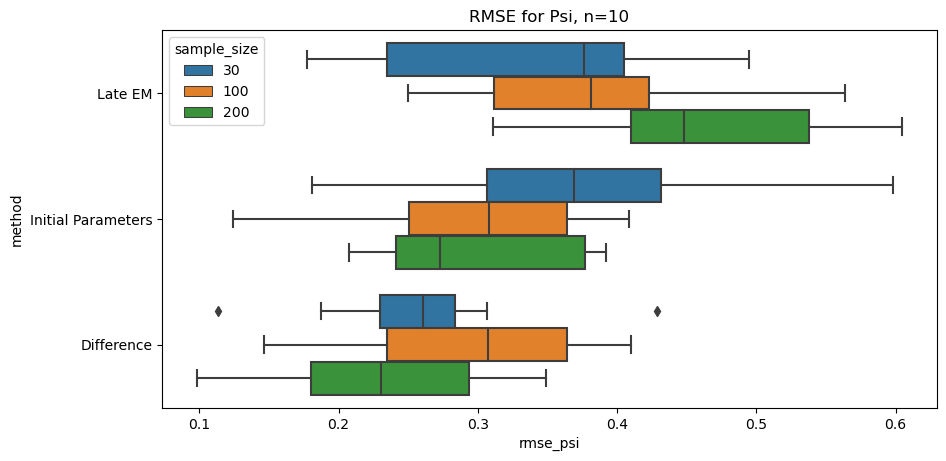

In [43]:
model_boxplot(pyramid_Q_df, metric="rmse_psi", methods=["late_em", "initial", "difference"], title="RMSE for Psi")

## Experiment 2: Prediction of Competency Gain

In [44]:
single_metric_table(full_Q_df, "rmse_theta", caption="Median RMSE for the estimation of $\\theta$")

\begin{table}[H]
\centering
\caption{Median RMSE for the estimation of $\theta$, n=4}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.598 &  0.482 &  0.627 &  0.532 \\
    & \textbf{Initial Parameters} &  0.579 &  0.503 &  0.620 &  0.533 \\
    & \textbf{Late EM} &  0.602 &  0.483 &  0.629 &  0.533 \\
    & \textbf{Real Param.} &  0.535 &  0.411 &  0.578 &  0.475 \\
    & \textbf{Real early Param.} &  0.000 &  0.000 &  0.000 &  0.000 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.542 &  0.464 &  0.601 &  0.513 \\
    & \textbf{Initial Parameters} &  0.557 &  0.513 &  0.626 &  0.559 \\
    & \textbf{Late EM} &  0.537 &  0.465 &  0.602 &  0.508 \\
    & \textbf{Real Param.} &  0.513 &

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.598  0.482  0.627  0.532
            Initial Parameters  0.579  0.503  0.620  0.533
            Late EM             0.602  0.483  0.629  0.533
            Real Param.         0.535  0.411  0.578  0.475
            Real early Param.   0.000  0.000  0.000  0.000
100         Difference          0.542  0.464  0.601  0.513
            Initial Parameters  0.557  0.513  0.626  0.559
            Late EM             0.537  0.465  0.602  0.508
            Real Param.         0.513  0.442  0.576  0.492
            Real early Param.   0.000  0.000  0.000  0.000
200         Difference          0.562  0.442  0.598  0.494
            Initial Parameters  0.584  0.506  0.624  0.549
            Late EM             0.562  0.442  0.596  0.491
            Real Param.         0.535  0.410  0.574  0.492
            Real early Param.   0.000  0.000  0.000  0.000

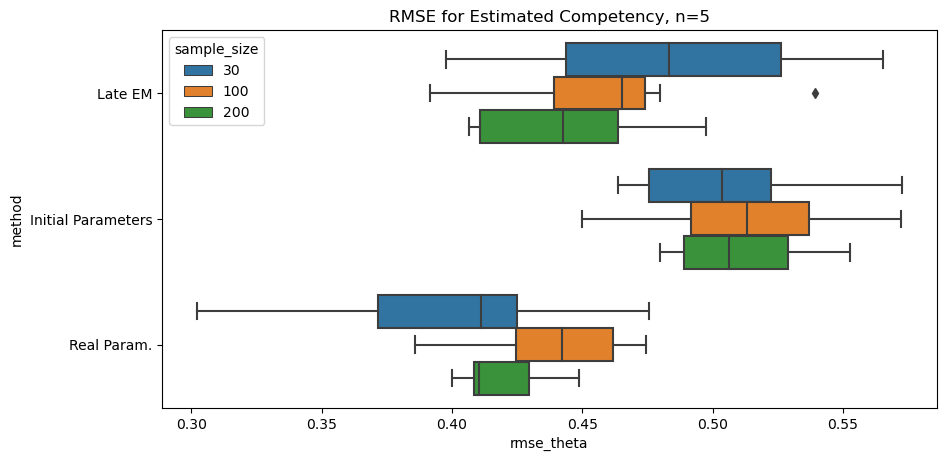

In [45]:
model_boxplot(full_Q_df, metric="rmse_theta", methods=["late_em", "initial", "real_parameters"], title="RMSE for Estimated Competency")
plt.savefig("results/plots/boxplot_full_Q_rmse_theta.png", bbox_inches="tight")

In [46]:
single_metric_table(full_Q_df, "rmse_gain_estimated", caption="Median RMSE for Competency Gain Estimation")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Estimation, n=4}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.873 &  0.847 &  0.903 &  0.861 \\
    & \textbf{Initial Parameters} &  0.863 &  1.076 &  0.958 &  1.074 \\
    & \textbf{Late EM} &  0.702 &  0.701 &  0.907 &  0.782 \\
    & \textbf{Real Param.} &  0.493 &  0.510 &  0.541 &  0.527 \\
    & \textbf{Real early Param.} &  0.748 &  0.656 &  0.934 &  0.697 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.897 &  0.804 &  0.870 &  0.857 \\
    & \textbf{Initial Parameters} &  0.844 &  0.849 &  0.887 &  1.047 \\
    & \textbf{Late EM} &  0.799 &  0.659 &  0.807 &  0.676 \\
    & \textbf{Real Param.} &  0.579 &

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.873  0.847  0.903  0.861
            Initial Parameters  0.863  1.076  0.958  1.074
            Late EM             0.702  0.701  0.907  0.782
            Real Param.         0.493  0.510  0.541  0.527
            Real early Param.   0.748  0.656  0.934  0.697
100         Difference          0.897  0.804  0.870  0.857
            Initial Parameters  0.844  0.849  0.887  1.047
            Late EM             0.799  0.659  0.807  0.676
            Real Param.         0.579  0.493  0.586  0.522
            Real early Param.   0.755  0.595  0.804  0.637
200         Difference          0.870  0.752  0.875  0.897
            Initial Parameters  0.829  0.883  0.973  1.002
            Late EM             0.793  0.626  0.825  0.700
            Real Param.         0.560  0.496  0.533  0.511
            Real early Param.   0.770  0.584  0.775  0.668

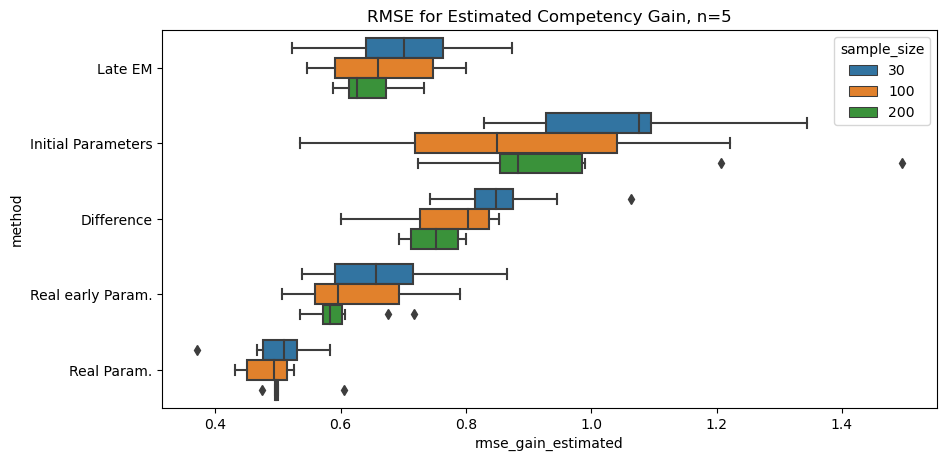

In [47]:
model_boxplot(full_Q_df, metric="rmse_gain_estimated", title="RMSE for Estimated Competency Gain", 
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_estimated.png", bbox_inches="tight")

In [48]:
single_metric_table(full_Q_df, "rmse_gain_pred_train", caption="Median RMSE for Competency Gain Prediction")

\begin{table}[H]
\centering
\caption{Median RMSE for Competency Gain Prediction, n=4}
\begin{tabular}{llrrrr}
\toprule
    & \textbf{latent\_dimension} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{3} \\
    & \textbf{item\_dimension} &     10 &     20 &     10 &     20 \\
\textbf{sample\_size} & \textbf{method} &        &        &        &        \\
\midrule
\multirow{5}{*}{\textbf{30 }} & \textbf{Difference} &  0.981 &  0.877 &  1.085 &  1.030 \\
    & \textbf{Initial Parameters} &  0.941 &  0.955 &  1.066 &  0.992 \\
    & \textbf{Late EM} &  0.948 &  0.912 &  1.090 &  0.998 \\
    & \textbf{Real Param.} &  0.715 &  0.694 &  0.861 &  0.844 \\
    & \textbf{Real early Param.} &  0.914 &  0.910 &  1.111 &  0.982 \\
\cline{1-6}
\multirow{5}{*}{\textbf{100}} & \textbf{Difference} &  0.991 &  0.904 &  1.048 &  1.058 \\
    & \textbf{Initial Parameters} &  1.016 &  0.920 &  1.042 &  1.026 \\
    & \textbf{Late EM} &  1.043 &  0.986 &  1.060 &  1.021 \\
    & \textbf{Real Param.} &  0.910 &

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\1552858579.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(bold_rows=True, multirow=True,


latent_dimension                    2             3       
item_dimension                     10     20     10     20
sample_size method                                        
30          Difference          0.981  0.877  1.085  1.030
            Initial Parameters  0.941  0.955  1.066  0.992
            Late EM             0.948  0.912  1.090  0.998
            Real Param.         0.715  0.694  0.861  0.844
            Real early Param.   0.914  0.910  1.111  0.982
100         Difference          0.991  0.904  1.048  1.058
            Initial Parameters  1.016  0.920  1.042  1.026
            Late EM             1.043  0.986  1.060  1.021
            Real Param.         0.910  0.720  0.797  0.806
            Real early Param.   1.078  1.028  1.088  1.027
200         Difference          0.953  0.883  1.057  1.049
            Initial Parameters  0.971  0.935  1.027  1.034
            Late EM             1.022  0.960  1.044  1.102
            Real Param.         0.806  0.766  0.847  0.893
            Real early Param.   1.149  0.978  1.054  1.117

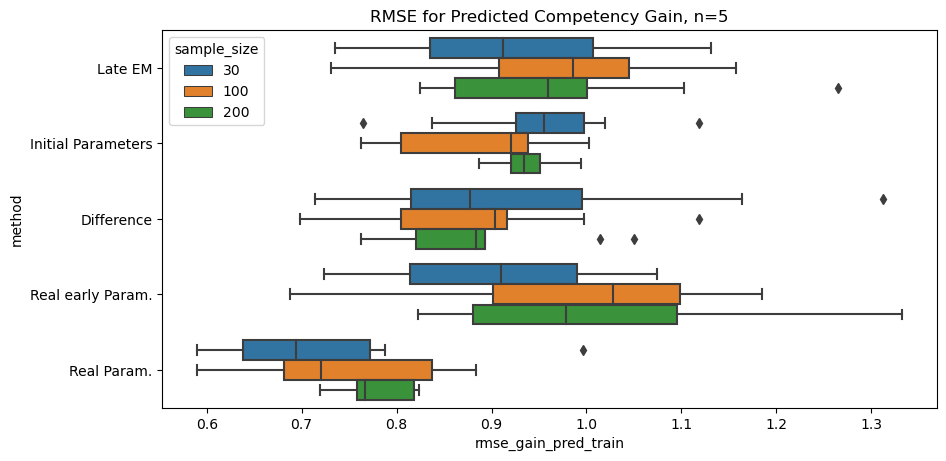

In [49]:
model_boxplot(full_Q_df, metric="rmse_gain_pred_train", title="RMSE for Predicted Competency Gain",
                methods=["late_em", "difference", "initial", "real_parameters", "pure_competency", "real_early"])
plt.savefig("results/plots/boxplot_full_Q_rmse_gain_predicted.png", bbox_inches="tight")

### CSEDM Data
base: uirt_lfa_model_csedm_final.ipynb

In [50]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import os
from os import path
import sys
sys.path.append(os.path.realpath("./models"))
sys.path.append(os.path.realpath("./em_algorithm"))
# Custom modules, import violates pep8, so we have to declare an exeption
if True:  # noqa: E402
    from mirt_2pl import mirt_2pl
    from mirt_2pl_gain import mirt_2pl_gain
    from e_step_mirt_2pl import e_step_ga_mml
    from e_step_mirt_2pl_gain import e_step_ga_mml_gain
    from m_step_mirt_2pl import m_step_ga_mml
    from m_step_mirt_2pl_gain import m_step_ga_mml_gain
    from em_algorithm import em_algo

In [51]:
semester = 'F19'
BASE_PATH = os.path.join('C:/Users/Jesper/Google Drive/Uni docs/Statistik/Masterarbeit/Daten/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

In [52]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

In [53]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U = imputer.fit_transform(U).round()
U = pd.DataFrame(U)

#Obtain Matrix of Response-vectors
V = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
V = imputer.fit_transform(V).round()
V = pd.DataFrame(V)


In [121]:
V.shape

(367, 20)

In [54]:
#Source: https://docs.google.com/spreadsheets/d/1-APxPAVP3PylM0fskzDNgpalj1DTuMqDLkgBC5QxJdg/edit#gid=0
item_skill_df = pd.read_csv("CSEDM Challenge/item_skill_relation.csv")
item_skill_df.columns

Index(['AssignmentID', 'ProblemID', 'Requirement', 'If/Else', 'NestedIf',
       'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr',
       'LogicCompareNum', 'LogicBoolean', 'StringFormat', 'StringConcat',
       'StringIndex', 'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex',
       'DefFunction'],
      dtype='object')

In [55]:
logic_skills = ['If/Else', 'NestedIf', 'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean']
string_skills = ['StringFormat', 'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual']
iter_skills = ['While', 'For', 'NestedFor', 'ArrayIndex']

logic_exercises = (np.sum(item_skill_df[logic_skills], axis=1) > 0)
string_exersises = (np.sum(item_skill_df[string_skills], axis=1) > 0)
iter_exercises = (np.sum(item_skill_df[iter_skills], axis=1) > 0)

full_Q = np.stack((logic_exercises, iter_exercises), axis=1)
early_Q = full_Q[0:30,:]
late_Q = full_Q[30:50, :]

In [56]:
# Fit early Model
early_model = mirt_2pl(latent_dimension=2, item_dimension=U.shape[1], Q=early_Q)
early_model.initialize_from_responses(response_data=U)
e_step = e_step_ga_mml(model=early_model)
m_step = m_step_ga_mml(
    early_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=early_model)


start_time = time.time()
em.fit([U.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(U)
estimated_early_item_parameters = em.model.item_parameters
estimated_early_person_parameters = em.model.person_parameters

EM Iteration 2


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[1.     0.3911]
 [0.3911 1.    ]]
Step: 2: current parameter_diff: 7.134025421380171, current marginal loglikelihood: -5618.6541123756315
EM Iteration 3


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.     0.3351]
 [0.3351 1.    ]]
Step: 3: current parameter_diff: 5.53047436695893, current marginal loglikelihood: -5594.441341467982
EM Iteration 4
Current Monte Carlo Sample size: 349
[[0.9999 0.2892]
 [0.2892 1.    ]]
Step: 4: current parameter_diff: 3.011743299629729, current marginal loglikelihood: -5583.595999087121
EM Iteration 5


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[0.9999 0.2687]
 [0.2687 0.9999]]
Step: 5: current parameter_diff: 1.8836048424977838, current marginal loglikelihood: -5585.480720709458
EM Iteration 6
Current Monte Carlo Sample size: 406
[[1.    0.258]
 [0.258 1.   ]]
Step: 6: current parameter_diff: 0.5613229200033654, current marginal loglikelihood: -5578.141946533071
EM Iteration 7
Current Monte Carlo Sample size: 438
[[1.     0.2617]
 [0.2617 1.    ]]
Step: 7: current parameter_diff: 0.7267009310104136, current marginal loglikelihood: -5578.269358803714
EM Iteration 8
Current Monte Carlo Sample size: 473
[[1.     0.2675]
 [0.2675 0.9999]]
Step: 8: current parameter_diff: 1.3830720566378225, current marginal loglikelihood: -5579.200739151672
EM Iteration 9
Current Monte Carlo Sample size: 510
[[1.     0.2619]
 [0.2619 1.    ]]
Step: 9: current parameter_diff: 0.4327521727378797, current marginal loglikelihood: -5575.024190859303


In [57]:
# Estimate the Late Variance


In [78]:
#Fit late Model
# Initialize Model
late_model = mirt_2pl_gain(item_dimension=20, latent_dimension=2, mu=np.ones(2),
                            early_sigma=estimated_early_person_parameters["covariance"],
                            Q=late_Q)
# TODO: Check if theta_hat can be used
late_model.initialize_from_responses(
    late_response_data=V, early_response_data=U,
    logit=True, sigma=False)
late_initial_parameters = late_model.get_parameters()
e_step = e_step_ga_mml_gain(
    model=late_model)
m_step = m_step_ga_mml_gain(
    late_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=late_model)

# Fit late model
start_time = time.time()
em.fit([V, pd.DataFrame(theta_hat)], max_iter=30,
        stop_threshold=0.01, person_method="BFGS")
run_time = (time.time() - start_time)
s_hat = late_model.predict_gain(
    V, pd.DataFrame(theta_hat))

s_pred_train = late_model.predict_gain(
    theta=pd.DataFrame(theta_hat))


EM Iteration 2


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[ 1.      0.2619 -0.3604 -0.383 ]
 [ 0.2619  1.     -0.362  -0.3649]
 [-0.3604 -0.362   0.8536  0.4855]
 [-0.383  -0.3649  0.4855  0.8369]]
Step: 2: current parameter_diff: 13.605281660896908, current marginal loglikelihood: -4338.012476024972
EM Iteration 3


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[ 1.      0.2619 -0.3242 -0.3682]
 [ 0.2619  1.     -0.34   -0.3323]
 [-0.3242 -0.34    0.8725  0.5045]
 [-0.3682 -0.3323  0.5045  0.877 ]]
Step: 3: current parameter_diff: 8.797547187050764, current marginal loglikelihood: -4363.313362662864
EM Iteration 4


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[ 1.      0.2619 -0.3198 -0.3732]
 [ 0.2619  1.     -0.33   -0.3438]
 [-0.3198 -0.33    0.8686  0.5286]
 [-0.3732 -0.3438  0.5286  0.9064]]
Step: 4: current parameter_diff: 5.9066901773657134, current marginal loglikelihood: -4307.946520007537
EM Iteration 5


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[ 1.      0.2619 -0.3107 -0.3648]
 [ 0.2619  1.     -0.3255 -0.3399]
 [-0.3107 -0.3255  0.867   0.5233]
 [-0.3648 -0.3399  0.5233  0.8847]]
Step: 5: current parameter_diff: 3.4559367245862944, current marginal loglikelihood: -4283.8447409849305
EM Iteration 6


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[ 1.      0.2619 -0.3106 -0.3631]
 [ 0.2619  1.     -0.329  -0.3314]
 [-0.3106 -0.329   0.858   0.4894]
 [-0.3631 -0.3314  0.4894  0.8714]]
Step: 6: current parameter_diff: 1.9570988308500716, current marginal loglikelihood: -4277.7520066765
EM Iteration 7


c:\Users\Jesper\Anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 406
[[ 1.      0.2619 -0.3277 -0.3757]
 [ 0.2619  1.     -0.3386 -0.3376]
 [-0.3277 -0.3386  0.8866  0.5164]
 [-0.3757 -0.3376  0.5164  0.8882]]
Step: 7: current parameter_diff: 3.323031359762537, current marginal loglikelihood: -4257.534166850768


### Item Parameters

In [135]:
#Item Parameters 

# Early 
early_A = early_model.item_parameters["discrimination_matrix"]
early_delta = early_model.item_parameters["intercept_vector"]
early_Q = early_model.item_parameters["q_matrix"]

# Late
late_A = late_model.item_parameters["discrimination_matrix"]
late_delta = late_model.item_parameters["intercept_vector"]
late_Q = late_model.item_parameters["q_matrix"]

In [136]:
shift = -1*np.quantile(s_hat, q=0.25, axis=0)
s_hat_shift = s_hat + shift
mu_shift = late_model.person_parameters["mean"][2:4] + shift
late_delta_shift = late_delta - np.dot(late_A, shift)

In [137]:
def item_parameter_table(A, Q, delta, latent_description=["Logic", "Iteration"], caption="", n=367):
    data = pd.DataFrame(np.concatenate((Q, A), axis=1))
    data.columns = pd.MultiIndex.from_product([['Q', 'A'], latent_description],
                                     names=['Param.', 'Latent dim.'])
    delta_df = pd.DataFrame(np.expand_dims(delta, 1), columns=[("$\Delta$", "")])
    data = pd.concat((data, delta_df), axis=1)
    data = np.round(data, 3)
    print(data.to_latex(bold_rows=True, multicolumn=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(data)

In [138]:
item_parameter_table(A=early_A, Q=early_Q, delta=early_delta, caption="CSEDM: Early Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Early Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   1.0 &       0.0 &  0.843 &     0.000 &    1.674 \\
\textbf{1 } &   1.0 &       0.0 &  1.249 &     0.000 &    1.321 \\
\textbf{2 } &   1.0 &       0.0 &  0.935 &     0.000 &    1.305 \\
\textbf{3 } &   1.0 &       0.0 &  0.764 &     0.000 &    1.352 \\
\textbf{4 } &   1.0 &       0.0 &  1.134 &     0.000 &    1.251 \\
\textbf{5 } &   1.0 &       0.0 &  1.473 &     0.000 &    1.545 \\
\textbf{6 } &   1.0 &       0.0 &  1.000 &     0.000 &    1.163 \\
\textbf{7 } &   1.0 &       0.0 &  0.821 &     0.000 &    1.301 \\
\textbf{8 } &   1.0 &       0.0 &  1.000 &     0.000 &    1.124 \\
\textbf{9 } &   1.0 &       0.0 &  1.333 &     0.000 &    1.298 \\
\textbf{10} &   1.0 &       0.0 &  1.128 &     0.00

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             1.0       0.0  0.843     0.000    1.674
1             1.0       0.0  1.249     0.000    1.321
2             1.0       0.0  0.935     0.000    1.305
3             1.0       0.0  0.764     0.000    1.352
4             1.0       0.0  1.134     0.000    1.251
5             1.0       0.0  1.473     0.000    1.545
6             1.0       0.0  1.000     0.000    1.163
7             1.0       0.0  0.821     0.000    1.301
8             1.0       0.0  1.000     0.000    1.124
9             1.0       0.0  1.333     0.000    1.298
10            1.0       0.0  1.128     0.000    1.457
11            1.0       0.0  1.133     0.000    1.555
12            1.0       0.0  1.159     0.000    1.542
13            1.0       0.0  1.252     0.000    1.398
14            1.0       0.0  1.077     0.000    1.181
15            1.0       0.0  1.101     0.000    0.759
16            1.0       0.0  1.221     0.000    1.269
17            1.0       0.0  0.945     0.000    1.191
18            1.0       1.0  1.145     0.577    0.157
19            1.0       0.0  0.772     0.000    0.646
20            0.0       1.0  0.000     2.397    1.544
21            1.0       1.0  0.028     2.628    1.369
22            1.0       1.0  0.220     1.991    1.226
23            1.0       1.0  0.498     1.885    1.139
24            1.0       1.0  1.016     1.018    1.394
25            1.0       0.0  0.855     0.000    1.104
26            1.0       1.0  0.644     1.305    0.541
27            1.0       1.0  0.966     1.270    1.284
28            1.0       1.0  0.695     0.984    0.888
29            1.0       1.0  0.789     1.675    1.016

In [139]:
item_parameter_table(A=late_A, Q=late_Q, delta=late_delta_shift, caption="CSEDM: Late Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Late Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   0.0 &       1.0 &  0.000 &     0.372 &    1.254 \\
\textbf{1 } &   1.0 &       1.0 &  1.068 &     0.745 &    0.945 \\
\textbf{2 } &   1.0 &       1.0 &  1.240 &     0.035 &    1.660 \\
\textbf{3 } &   1.0 &       1.0 &  1.061 &     1.263 &    0.571 \\
\textbf{4 } &   1.0 &       1.0 &  1.372 &     0.502 &    0.727 \\
\textbf{5 } &   1.0 &       1.0 &  0.774 &     0.645 &    0.727 \\
\textbf{6 } &   1.0 &       1.0 &  1.057 &     0.613 &    0.690 \\
\textbf{7 } &   1.0 &       1.0 &  0.305 &     1.158 &    0.859 \\
\textbf{8 } &   1.0 &       1.0 &  0.995 &     1.826 &    0.631 \\
\textbf{9 } &   1.0 &       1.0 &  0.221 &     1.138 &    0.244 \\
\textbf{10} &   1.0 &       1.0 &  0.906 &     0.985

C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             0.0       1.0  0.000     0.372    1.254
1             1.0       1.0  1.068     0.745    0.945
2             1.0       1.0  1.240     0.035    1.660
3             1.0       1.0  1.061     1.263    0.571
4             1.0       1.0  1.372     0.502    0.727
5             1.0       1.0  0.774     0.645    0.727
6             1.0       1.0  1.057     0.613    0.690
7             1.0       1.0  0.305     1.158    0.859
8             1.0       1.0  0.995     1.826    0.631
9             1.0       1.0  0.221     1.138    0.244
10            1.0       1.0  0.906     0.985    0.858
11            1.0       1.0  0.462     1.728    1.339
12            1.0       1.0  0.476     1.434    0.438
13            1.0       1.0  0.404     1.051    0.948
14            0.0       1.0  0.000     0.985    1.579
15            1.0       1.0  0.272     1.867    0.915
16            1.0       1.0  0.493     1.609    0.166
17            1.0       1.0  0.464     1.149    0.706
18            0.0       1.0  0.000     1.738    0.981
19            0.0       1.0  0.000     1.402    1.102

(array([[  1.,   4.,  14.,  54.,  82., 126.,  68.,  16.,   2.,   0.],
        [  0.,   2.,  25.,  48.,  78.,  97.,  77.,  30.,   7.,   3.]]),
 array([-1.88954887, -1.44428199, -0.99901511, -0.55374824, -0.10848136,
         0.33678552,  0.7820524 ,  1.22731927,  1.67258615,  2.11785303,
         2.56311991]),
 <a list of 2 BarContainer objects>)

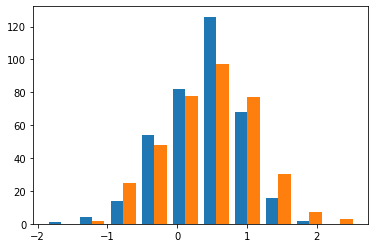

In [140]:
plt.hist(s_hat_shift)

### Person Parameters

In [143]:
#early
early_covariance = early_model.person_parameters["covariance"]
early_mu = np.zeros(2)

#late
late_covariance = late_model.person_parameters["covariance"]
late_mu = np.concatenate((early_mu, mu_shift), axis=0)

In [163]:
def table_person_parameters(covariance, mu, latent_description=["Logic", "Iteration"], caption="", n=367):
    cov_df = pd.DataFrame(covariance)
    index = pd.MultiIndex.from_product([['Prior Competence', 'Competence Gain'], latent_description],
                        names=['Param.', 'Latent dim.'])
    cov_df.columns = index
    mu_df = pd.DataFrame(np.expand_dims(mu, axis=1), columns=[("Mean", "")])
    person_df = pd.concat((cov_df, mu_df), axis=1)
    person_df.index = index
    person_df = np.round(person_df, 3)
    print(person_df.to_latex(bold_rows=True, multicolumn=True, 
                                caption=caption+", n={0}".format(n), 
                                position="H", escape=False))
    return(person_df)
    

In [165]:
table_person_parameters(covariance=late_covariance, mu=late_mu, caption="CSEDM: Person Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Person Parameters, n=367}
\begin{tabular}{llrrrrr}
\toprule
                & \textbf{Param.} & \multicolumn{2}{l}{Prior Competence} & \multicolumn{2}{l}{Competence Gain} &   Mean \\
                & \textbf{Latent dim.} &            Logic & Iteration &           Logic & \multicolumn{2}{l}{Iteration} \\
\textbf{Param.} & \textbf{Latent dim.} &                  &           &                 &           &        \\
\midrule
\textbf{Prior Competence} & \textbf{Logic} &            1.000 &     0.262 &          -0.328 &    -0.376 &  0.000 \\
                & \textbf{Iteration} &            0.262 &     1.000 &          -0.339 &    -0.338 &  0.000 \\
\textbf{Competence Gain} & \textbf{Logic} &           -0.328 &    -0.339 &           0.887 &     0.516 &  0.677 \\
                & \textbf{Iteration} &           -0.376 &    -0.338 &           0.516 &     0.888 &  0.832 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\Jesper\AppData\Local\Temp\ipykernel_4888\1204287124.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(person_df.to_latex(bold_rows=True, multicolumn=True,


Param.                       Prior Competence           Competence Gain  \
Latent dim.                             Logic Iteration           Logic   
Param.           Latent dim.                                              
Prior Competence Logic                  1.000     0.262          -0.328   
                 Iteration              0.262     1.000          -0.339   
Competence Gain  Logic                 -0.328    -0.339           0.887   
                 Iteration             -0.376    -0.338           0.516   

Param.                                   Mean  
Latent dim.                  Iteration         
Param.           Latent dim.                   
Prior Competence Logic          -0.376  0.000  
                 Iteration      -0.338  0.000  
Competence Gain  Logic           0.516  0.677  
                 Iteration       0.888  0.832

# Gain Visualization